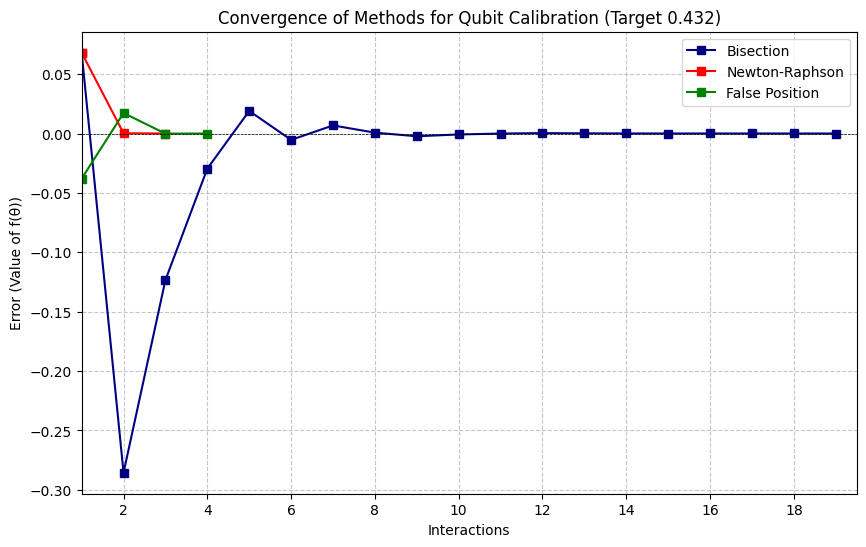

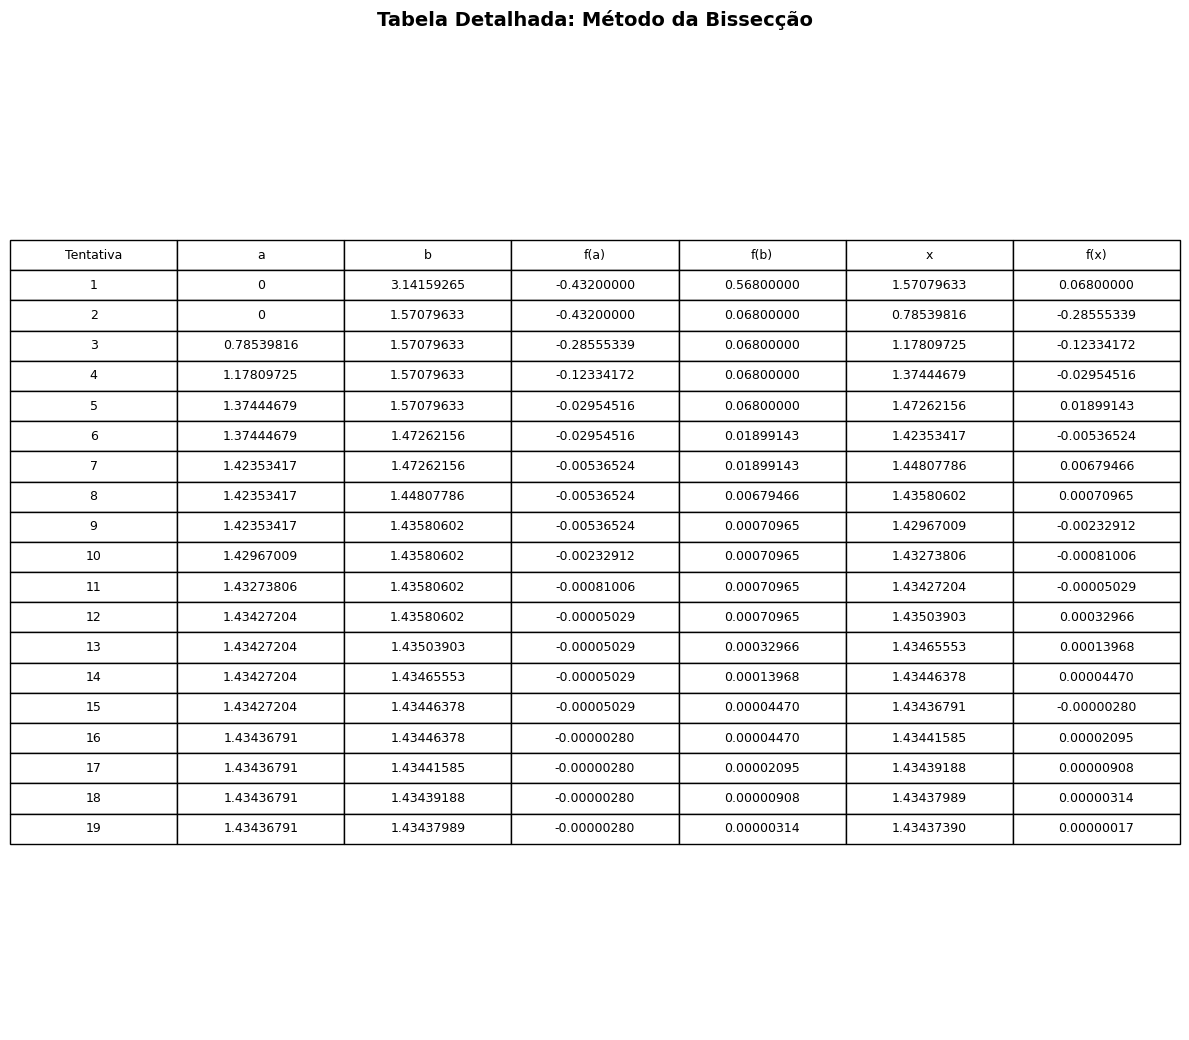

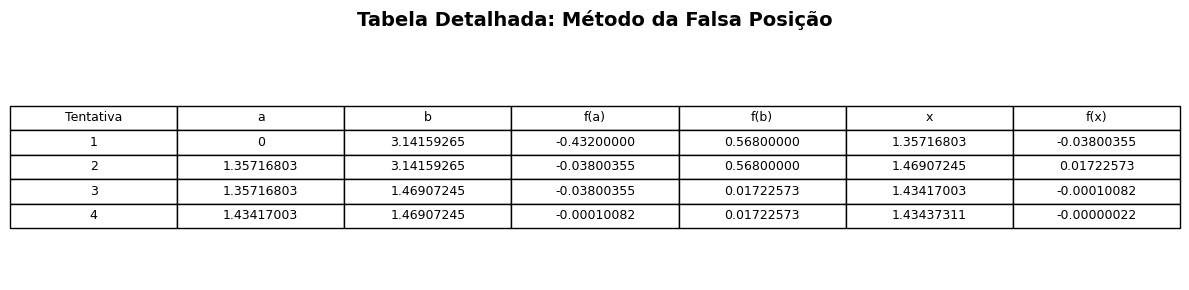

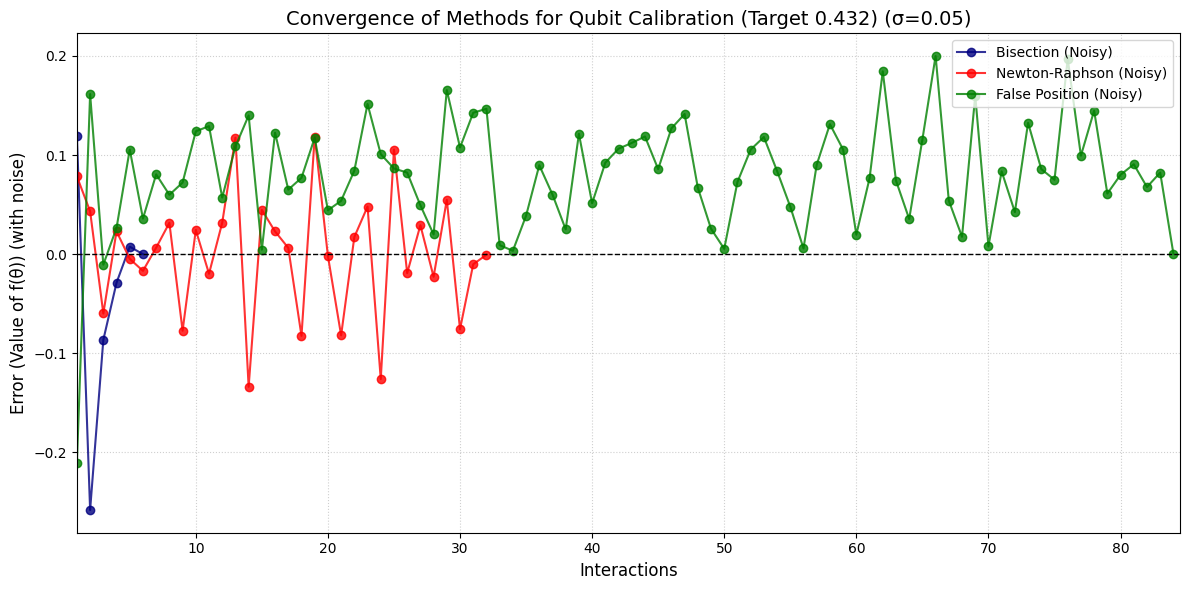

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Definição do alvo da calibração do Qubit (probabilidade exata de medir |1>)
P_TARGET = 0.432

# Função objetivo: f(theta) = Probabilidade_Calculada - Probabilidade_Alvo
def f(theta):
    return np.sin(theta / 2)**2 - P_TARGET

# Derivada da função (necessária pro método de Newton-Raphson)
def df(theta):
    return 0.5 * np.sin(theta)

def metodo_bisseccao(func_obj, a, b, stop, max_tentativas=100):
    dados = []
    # Checagem básica de troca de sinal no intervalo
    if func_obj(a) * func_obj(b) >= 0:
        return None, dados
    
    for k in range(max_tentativas):
        val_a = a
        val_b = b
        val_fa = func_obj(a)
        val_fb = func_obj(b)
        
        # Média aritmétrica
        x = (a + b) / 2
        val_fx = func_obj(x)
        
        # Guardando o histórico pra plotar depois
        dados.append({
            'Metodo': 'Bissecção',
            'Tentativa': k + 1,      
            'a': val_a,
            'b': val_b,
            'f(a)': val_fa,
            'f(b)': val_fb,
            'x': x,
            'f(x)': val_fx
        })
        
        # Critério de parada
        if abs(val_fx) < stop:
            return x, dados
        
        # Atualiza o intervalo dependendo do sinal (TVM)
        if val_fa * val_fx < 0:
            b = x
        else:
            a = x
            
    return x, dados

def metodo_falsa_posicao(func_obj, a, b, tol, max_tentativas=100):
    dados = []
    if func_obj(a) * func_obj(b) >= 0: return None, dados
    
    for k in range(max_tentativas):
        val_a = a
        val_b = b
        val_fa = func_obj(a)
        val_fb = func_obj(b)
        
        # Calcula a raiz aproximada pela média ponderada
        # Proteção contra divisão por zero caso f(a) e f(b) sejam 0
        denom = abs(val_fb) + abs(val_fa)
        if denom == 0: break

        x = (a * abs(val_fb) + b * abs(val_fa)) / denom
        val_fx = func_obj(x)
        
        dados.append({
            'Metodo': 'Falsa Posição',
            'Tentativa': k + 1,
            'a': val_a,
            'b': val_b,
            'f(a)': val_fa,
            'f(b)': val_fb,
            'x': x,
            'f(x)': val_fx
        })
        
        if abs(val_fx) < tol:
            return x, dados
        
        # Ajuste do intervalo (TVM)
        if val_fa * val_fx < 0:
            b = x
        else:
            a = x
    return x, dados

def metodo_newton_raphson(func_obj, deriv_obj, x0, tol, max_tentativas=100):
    dados = []
    x = x0
    for k in range(max_tentativas):
        fx = func_obj(x)
        dfx = deriv_obj(x)
        
        # Evita divisão por zero
        if dfx == 0: break
        
        # Canditado a raiz
        x_novo = x - (fx / dfx)
        
        dados.append({
            'Metodo': 'Newton-Raphson', 
            'Tentativa': k + 1, 
            'x': x_novo, 
            'f(x)': fx
        })
        
        if abs(fx) < tol:
            return x_novo, dados
        x = x_novo
    return x, dados



# --- Execução (Função Sem Ruído) ---

criterio_de_parada = 0.000001

# Definindo intervalo de busca entre 0 e Pi e rodando os métodos com a função 'f'
root_bis, dados_bis = metodo_bisseccao(f, 0, np.pi, criterio_de_parada)
root_fal, dados_fal = metodo_falsa_posicao(f, 0, np.pi, criterio_de_parada)
# Chute inicial para o método de Newton (Pi/2)
root_new, dados_new = metodo_newton_raphson(f, df, np.pi/2, criterio_de_parada)


# --- Plots Sem Ruído ---

# 1. Gráfico de Convergência
plt.figure(figsize=(10, 6))

methods_config = [
    ('Bisection', dados_bis, 'navy'),
    ('Newton-Raphson', dados_new, 'red'),
    ('False Position', dados_fal, 'green')
]

max_t = 0
for nome, dados, cor in methods_config:
    tentativas = [d['Tentativa'] for d in dados]
    valores = [d['f(x)'] for d in dados]
    
    # Atualiza o máximo de tentativas pra ajustar o eixo X depois
    if len(tentativas) > 0:
        max_t = max(max_t, max(tentativas))
        
    plt.plot(tentativas, valores, '-s', label=nome, color=cor)

plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title(f'Convergence of Methods for Qubit Calibration (Target {P_TARGET})')
plt.xlabel('Interactions')
plt.ylabel('Error (Value of f(θ))')

# Ajuste para o eixo X a usar inteiros
plt.xlim(left=1, right=max_t + 0.5 if max_t > 0 else None)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 

plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.show()

# 2. Tabelas Sem Ruído
def plot_table(title, data, columns):
    cell_text = []
    for row in data:
        formatted_row = []
        for col in columns:
            # Tratamento pra evitar erro no Newton que não tem colunas 'a' e 'b'
            val = row.get(col, '') 
            if isinstance(val, (float, np.floating)):
                formatted_row.append(f"{val:.8f}")
            else:
                formatted_row.append(str(val))
        cell_text.append(formatted_row)
        
    fig, ax = plt.subplots(figsize=(12, len(data) * 0.5 + 1))
    ax.axis('off')
    ax.set_title(title, fontsize=14, weight='bold', pad=20)
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    plt.tight_layout()
    plt.show()

cols_table = ['Tentativa', 'a', 'b', 'f(a)', 'f(b)', 'x', 'f(x)']

# Gerando as tabelas detalhadas passo a passo
plot_table("Tabela Detalhada: Método da Bissecção", dados_bis, cols_table)
plot_table("Tabela Detalhada: Método da Falsa Posição", dados_fal, cols_table)






# --- Execução (Função Com Ruído) ---

NOISE_STD = 0.05 # Desvio padrão do ruído (simula incerteza na medição)

# Nova função com ruído
def f_noisy(theta):
    noise = np.random.normal(0, NOISE_STD)
    return f(theta) + noise

# Executando os métodos com a função ruidosa
max_iter_noisy = 100
criterio_de_parada_ruido = 0.001
root_bis_n, dados_bis_n = metodo_bisseccao(f_noisy, 0, np.pi, criterio_de_parada_ruido, max_tentativas=max_iter_noisy)
root_fal_n, dados_fal_n = metodo_falsa_posicao(f_noisy, 0, np.pi, criterio_de_parada_ruido, max_tentativas=max_iter_noisy)
root_new_n, dados_new_n = metodo_newton_raphson(f_noisy, df, np.pi/2, criterio_de_parada_ruido, max_tentativas=max_iter_noisy)




# --- Plots Com Ruído ---

plt.figure(figsize=(12, 6))

methods_config_noisy = [
    ('Bisection (Noisy)', dados_bis_n, 'navy'),
    ('Newton-Raphson (Noisy)', dados_new_n, 'red'),
    ('False Position (Noisy)', dados_fal_n, 'green')
]

max_t_n = 0
for nome, dados, cor in methods_config_noisy:
    if dados is None or len(dados) == 0: continue
    
    tentativas = [d['Tentativa'] for d in dados]
    valores = [d['f(x)'] for d in dados]
    
    if len(tentativas) > 0:
        max_t_n = max(max_t_n, max(tentativas))
        
    plt.plot(tentativas, valores, '-o', label=nome, color=cor, alpha=0.8, linewidth=1.5)

plt.axhline(0, color='black', linewidth=1, linestyle='--')

plt.title(f'Convergence of Methods for Qubit Calibration (Target {P_TARGET}) (σ={NOISE_STD})', fontsize=14)
plt.xlabel('Interactions', fontsize=12)
plt.ylabel('Error (Value of f(θ)) (with noise)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle=':', alpha=0.6)

plt.xlim(left=1, right=max_t_n + 0.5 if max_t_n > 0 else None)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 

plt.tight_layout()
plt.show()